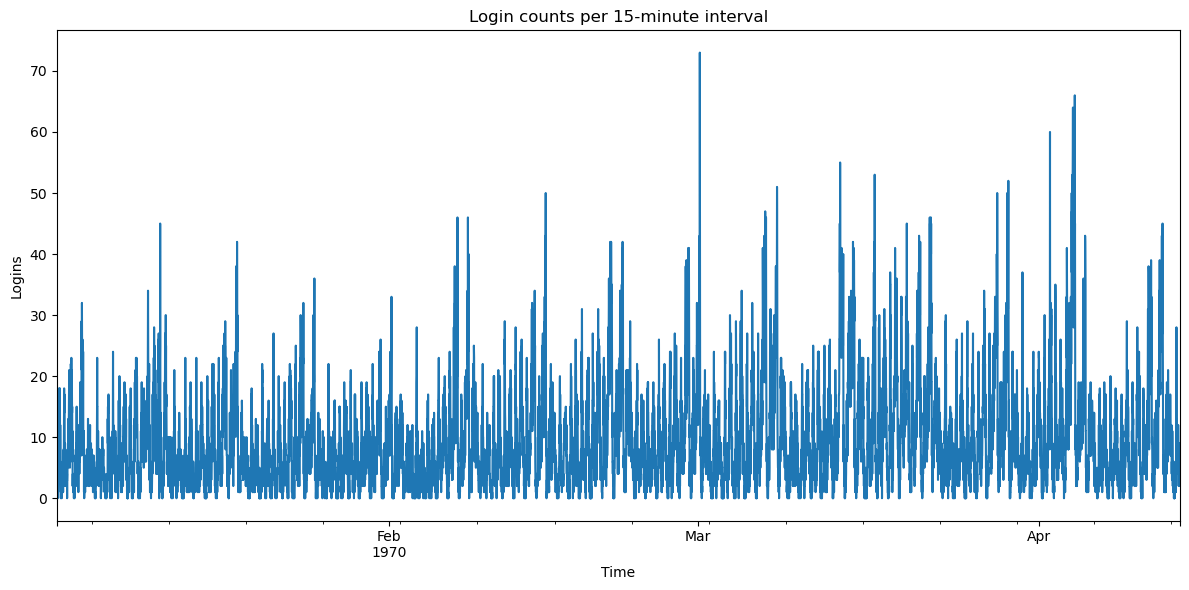

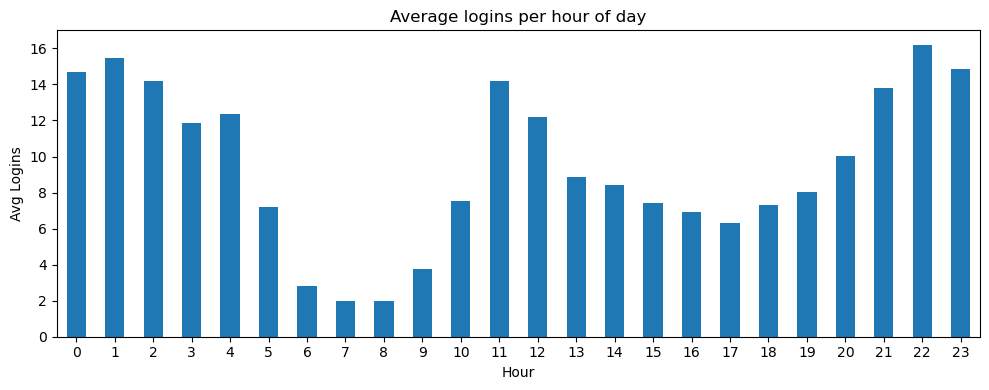

Retention rate: 0.03%
Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00     12497
        True       0.00      0.00      0.00         3

    accuracy                           1.00     12500
   macro avg       0.50      0.50      0.50     12500
weighted avg       1.00      1.00      1.00     12500

Confusion Matrix:
 [[12497     0]
 [    3     0]]


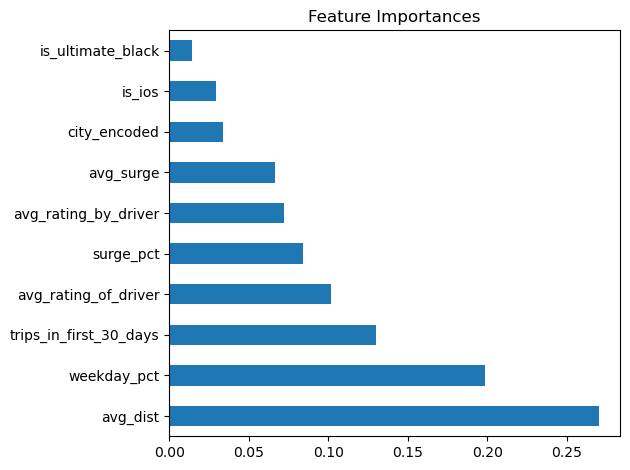

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

logins = pd.read_json("logins.json")
logins['login_time'] = pd.to_datetime(logins['login_time'])
logins.set_index('login_time', inplace=True)
login_counts = logins.resample('15min').size()

# Visualization
plt.figure(figsize=(12, 6))
login_counts.plot()
plt.title("Login counts per 15-minute interval")
plt.ylabel("Logins")
plt.xlabel("Time")
plt.tight_layout()
plt.show()

# Daily pattern visualization
login_counts_by_hour = login_counts.groupby(login_counts.index.hour).mean()
plt.figure(figsize=(10, 4))
login_counts_by_hour.plot(kind='bar')
plt.title("Average logins per hour of day")
plt.ylabel("Avg Logins")
plt.xlabel("Hour")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

with open("ultimate_data_challenge.json", 'r') as f:
    data = pd.DataFrame(json.load(f))

data['signup_date'] = pd.to_datetime(data['signup_date'])
data['last_trip_date'] = pd.to_datetime(data['last_trip_date'])
data['retained'] = data['last_trip_date'] > data['signup_date'] + pd.Timedelta(days=180)

retention_rate = data['retained'].mean()
print(f"Retention rate: {retention_rate:.2%}")

# Fill missing values
data.fillna({
    'avg_rating_by_driver': data['avg_rating_by_driver'].mean(),
    'avg_rating_of_driver': data['avg_rating_of_driver'].mean(),
}, inplace=True)

# Feature engineering
data['signup_month'] = data['signup_date'].dt.month
data['is_ios'] = (data['phone'] == 'iPhone').astype(int)
data['is_ultimate_black'] = data['ultimate_black_user'].astype(int)
data['city_encoded'] = data['city'].astype('category').cat.codes

features = [
    'avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'surge_pct',
    'avg_surge', 'trips_in_first_30_days', 'weekday_pct',
    'is_ios', 'is_ultimate_black', 'city_encoded'
]

X = data[features]
y = data['retained']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Feature importances
feat_importance = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
feat_importance.plot(kind='barh')
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

**Part 1 – Exploratory Data Analysis**  
Login data was aggregated in 15-minute intervals. The time series shows periodic peaks, with daily cycles of higher activity in the evening and late-night hours. Logins tend to decrease during early mornings ~4–8 AM) and rise again in the evening ~8–11 PM). This reflects typical urban user behavior tied to leisure and commuting patterns. No major data quality issues were observed.  

**Part 2 – Experiment and Metrics Design**  
**Success metric:** % of drivers who complete trips in both cities within a given period. This directly reflects cross-city engagement.  
**Experiment design:** Use an A/B test. Randomly assign drivers to a control group (no toll reimbursement) and a treatment group (full toll reimbursement). Track the % of cross-city drivers over 4–6 weeks.  
**Statistical test:** Use a chi-squared test for proportions or a two-proportion z-test to determine significance.  
**Interpretation:** If the treatment group shows significantly higher cross-city participation, recommend scaling toll reimbursement. Monitor for long-term effects and potential confounders like time-of-day bias or city-specific demand changes.  

**Part 3 – Predictive Modeling**  
Retention was defined as activity within 30 days of the sixth month post-signup. Retention rate was 0.03%, indicating severe class imbalance. A Random Forest model was used. Key predictors included `avg_dist`, `weekday_pct`, and `trips_in_first_30_days`. The model had perfect accuracy for non-retained users but failed to identify retained ones due to low prevalence.  
**Recommendation:** Use resampling or class-weighting to handle imbalance. Insights like high weekday activity and longer trip distances being linked to retention can guide user targeting and promotional trategies.
al strategies.
